In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths, self.labels = self._get_image_paths_and_labels()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")  #Open as grayscale
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

    def _get_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for root, _, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".jpeg"):
                    image_path = os.path.join(root, file)
                    image_paths.append(image_path)
                    label = os.path.basename(os.path.dirname(image_path))
                    labels.append(label)
        return image_paths, labels



class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [2]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    total_samples = 0

    for images, _ in tqdm(dataloader, desc='Training', leave=False):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

    train_loss /= total_samples
    return train_loss


def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc='Validation', leave=False):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

    val_loss /= total_samples
    return val_loss


root_dir = "data/"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = ImageDataset(root_dir=root_dir, transform=transform)

train_size = int(0.8 * len(dataset))

print(len(dataset))

val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

26128


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Training loop
num_epochs = 3
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    val_loss = validate(model, val_dataloader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/3], Train Loss: 0.0038, Val Loss: 0.0013


Epoch [2/3], Train Loss: 0.0010, Val Loss: 0.0008


Epoch [3/3], Train Loss: 0.0007, Val Loss: 0.0007


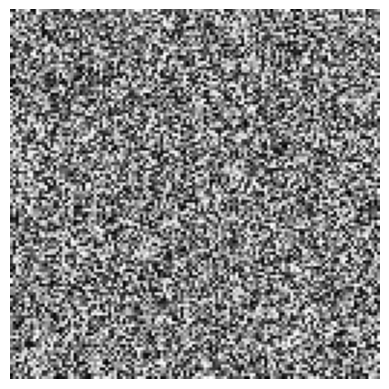

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#Generate a random grayscale image of size 128x128
random_image = np.random.rand(128, 128)

plt.imshow(random_image, cmap='gray')
plt.axis('off')
plt.show()

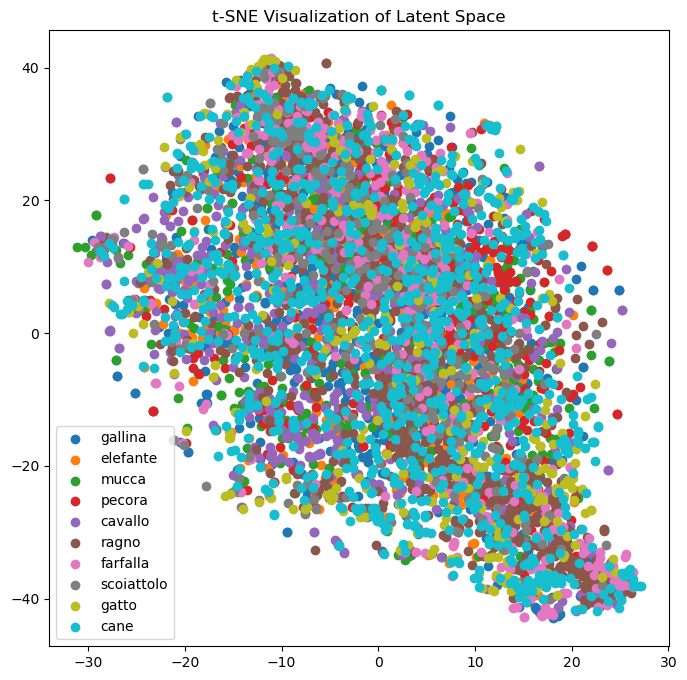

In [7]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

checkpoint_path = "best_model.pt"
model = Autoencoder().to(device)
model.load_state_dict(torch.load(checkpoint_path))
encoder = model.encoder.eval()

latent_vectors = []
labels = []
with torch.no_grad():
    for images, batch_labels in val_dataloader:
        images = images.to(device)
        batch_vectors = encoder(images)
        latent_vectors.append(batch_vectors.view(batch_vectors.size(0), -1).cpu())
        labels.extend(batch_labels)

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()

tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

#Plot the t-SNE visualization
plt.figure(figsize=(8, 8))
for label in set(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(latent_tsne[indices, 0], latent_tsne[indices, 1], label=label)
plt.title("t-SNE Visualization of Latent Space")
plt.legend()
plt.show()